In [0]:
%pip install pmdarima prophet xgboost joblib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/50.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/689.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 686.1/689.1 kB 35.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.1 MB ? eta -:--:--
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/12.1 MB 57.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/12.1 MB 70.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 8.6/12.1 MB 82.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 12.1/12.1 MB 102.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 12.1/12.1 MB 102.3 MB/s eta 0:00:01

In [0]:
%restart_python

In [0]:
# ✨ USE YOUR REAL VALUES BELOW

client_id      = ""     # Application (client) ID
tenant_id      = ""      # Directory (tenant) ID
client_secret  = ""          # Client Secret (Value)

storage_account = "azuresupply2605"

spark.conf.set(f"fs.azure.account.auth.type.{storage_account}.dfs.core.windows.net", "OAuth")
spark.conf.set(f"fs.azure.account.oauth.provider.type.{storage_account}.dfs.core.windows.net",
               "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")

spark.conf.set(f"fs.azure.account.oauth2.client.id.{storage_account}.dfs.core.windows.net", client_id)
spark.conf.set(f"fs.azure.account.oauth2.client.secret.{storage_account}.dfs.core.windows.net", client_secret)

spark.conf.set(f"fs.azure.account.oauth2.client.endpoint.{storage_account}.dfs.core.windows.net",
               f"https://login.microsoftonline.com/{tenant_id}/oauth2/token")


In [0]:
# STEP 1: Load GOLD table cleanly after restart

gold_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/final_gold/"

gold_df = spark.read.format("delta").load(gold_path)

print("Rows in Gold:", gold_df.count())
gold_df.printSchema()

display(gold_df.limit(5))


Rows in Gold: 10962
root
 |-- date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- service: string (nullable = true)
 |-- usage_units: integer (nullable = true)
 |-- peak_usage_units: integer (nullable = true)
 |-- vm_count: integer (nullable = true)
 |-- storage_tb: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- econ_index: integer (nullable = true)
 |-- downtime_min: integer (nullable = true)
 |-- usage_lag_1: double (nullable = true)
 |-- usage_lag_7: double (nullable = true)
 |-- week_over_week_growth: double (nullable = true)
 |-- seasonality_factor: double (nullable = true)
 |-- demand_actual: integer (nullable = true)
 |-- cloud_demand_index: integer (nullable = true)
 |-- gdp_growth: double (nullable = true)
 |-- inflation: double (nullable = true)
 |-- competitor_price_index: integer (nullable = true)



date,region,service,usage_units,peak_usage_units,vm_count,storage_tb,season,econ_index,downtime_min,usage_lag_1,usage_lag_7,week_over_week_growth,seasonality_factor,demand_actual,cloud_demand_index,gdp_growth,inflation,competitor_price_index
2022-10-06,East US,Compute,157899,175674,10465,0,Autumn,109,0,79757.0,105464.0,49.71838731699916,1.1379450666416375,157899,109,3.9173546029233512,5.578609903773472,117
2023-09-11,East US,Compute,166349,195137,13989,0,Autumn,92,1,85447.0,117923.0,41.065780212511555,1.1743873636069189,166349,88,3.9108112837826705,7.406119690793604,92
2020-02-10,East US,Storage,0,0,0,855,Winter,109,0,0.0,0.0,0.0,1.1490928323493095,0,73,2.2035604657016576,7.911764036647351,92
2020-05-08,East US,Storage,0,0,0,977,Spring,100,1,0.0,0.0,0.0,1.0769441644619129,0,117,4.61814317588024,7.450322288235068,112
2021-02-02,East US,Storage,0,0,0,743,Winter,104,0,0.0,0.0,0.0,1.054067234234836,0,99,3.963777906046026,7.474451532852226,92


In [0]:
from pyspark.sql import functions as F
import pandas as pd

# Target column for forecasting (choose one)
target_col = "demand_actual"   # or "usage_units"

# List of regions
compute_regions = ["East US", "West Europe", "Central India"]

# Dictionary to store results
compute_data = {}

horizon = 30  # last 30 days for test split

for region in compute_regions:
    print(f"\n============================")
    print(f"Processing Compute Region: {region}")
    print(f"============================")
    
    # STEP 2: Filter Compute data by region
    compute_df = (
        gold_df
        .filter(
            (F.col("service") == "Compute") &
            (F.col("region") == region)
        )
        .select("date", target_col)
        .orderBy("date")
    )
    
    print(f"Rows found: {compute_df.count()}")
    
    # Convert to pandas
    pdf = compute_df.toPandas()
    pdf['date'] = pd.to_datetime(pdf['date'])
    pdf = pdf.sort_values('date')
    pdf = pdf.set_index('date')
    
    # Select target series
    y = pdf[target_col]
    
    # STEP 3: Train-test split
    train = y.iloc[:-horizon]
    test  = y.iloc[-horizon:]
    
    print("Train size:", len(train), " Test size:", len(test))
    
    # Store in dictionary for later model training
    compute_data[region] = {
        "full": y,
        "train": train,
        "test": test
    }

print("\n✔️ Step 2 & 3 completed for all Compute regions!")



Processing Compute Region: East US
Rows found: 1827
Train size: 1797  Test size: 30

Processing Compute Region: West Europe
Rows found: 1827
Train size: 1797  Test size: 30

Processing Compute Region: Central India
Rows found: 1827
Train size: 1797  Test size: 30

✔️ Step 2 & 3 completed for all Compute regions!


In [0]:
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

arima_results = {}

print("========== ARIMA MODEL TRAINING ==========\n")

for region, data in compute_data.items():
    print(f"Training ARIMA for region: {region}")
    print("---------------------------------------------")
    
    y_train = data["train"]
    y_test  = data["test"]
    
    # Fit ARIMA automatically
    model = auto_arima(
        y_train,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True
    )
    
    # Forecast next 30 days
    forecast = model.predict(n_periods=len(y_test))
    forecast = pd.Series(forecast, index=y_test.index)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    
    print(f"MAPE for {region}: {mape:.2f}%\n")
    
    # Store all results
    arima_results[region] = {
        "model": model,
        "forecast": forecast,
        "mape": mape
    }

print("=========== ARIMA Training Completed ===========")


========== ARIMA MODEL TRAINING ==========

Training ARIMA for region: East US
---------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run funny-penguin-100 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/0d1368943ada4ac59725c44ae5cb09dc
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for East US: 33.51%

Training ARIMA for region: West Europe
---------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run learned-shrew-416 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/bbd5d39f01b94228adec731ade888600
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for West Europe: 32.59%

Training ARIMA for region: Central India
---------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run magnificent-hen-985 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/f995e077beca47b1954866769dac6a24
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for Central India: 38.92%

=========== ARIMA Training Completed ===========


In [0]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

sarimax_results = {}

print("========== SARIMAX MODEL TRAINING ==========\n")

for region, data in compute_data.items():
    print(f"Training SARIMAX for region: {region}")
    print("---------------------------------------------")

    y_train = data["train"]
    y_test = data["test"]

    # SARIMAX with weekly seasonality (7 days)
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast 30 days
    forecast = model.forecast(steps=len(y_test))
    forecast = pd.Series(forecast, index=y_test.index)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    print(f"MAPE for {region}: {mape:.2f}%\n")

    # Store results
    sarimax_results[region] = {
        "model": model,
        "forecast": forecast,
        "mape": mape
    }

print("=========== SARIMAX Training Completed ===========")


========== SARIMAX MODEL TRAINING ==========

Training SARIMAX for region: East US
---------------------------------------------
MAPE for East US: 31.20%

Training SARIMAX for region: West Europe
---------------------------------------------
MAPE for West Europe: 33.70%

Training SARIMAX for region: Central India
---------------------------------------------
MAPE for Central India: 38.37%

=========== SARIMAX Training Completed ===========


In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

holt_results = {}

print("========== HOLT-WINTERS (EXPONENTIAL SMOOTHING) TRAINING ==========\n")

for region, data in compute_data.items():
    print(f"Training Holt-Winters for region: {region}")
    print("---------------------------------------------")

    y_train = data["train"]
    y_test = data["test"]
    
    # Holt-Winters model
    model = ExponentialSmoothing(
        y_train,
        trend="add",
        seasonal="add",
        seasonal_periods=7
    ).fit()
    
    # Forecast next 30 days
    forecast = model.forecast(len(y_test))
    forecast = pd.Series(forecast, index=y_test.index)
    
    # MAPE
    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    print(f"MAPE for {region}: {mape:.2f}%\n")
    
    # Save
    holt_results[region] = {
        "model": model,
        "forecast": forecast,
        "mape": mape
    }

print("=========== Holt-Winters Training Completed ===========")


========== HOLT-WINTERS (EXPONENTIAL SMOOTHING) TRAINING ==========

Training Holt-Winters for region: East US
---------------------------------------------
MAPE for East US: 31.18%

Training Holt-Winters for region: West Europe
---------------------------------------------
MAPE for West Europe: 31.64%

Training Holt-Winters for region: Central India
---------------------------------------------
MAPE for Central India: 39.37%

=========== Holt-Winters Training Completed ===========


In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np

rf_results = {}

print("========== RANDOM FOREST MODEL TRAINING ==========\n")

for region in compute_regions:
    print(f"Training Random Forest for: {region}")
    print("-------------------------------------------")

    # Filter Spark DF for region
    sdf = (
        gold_df
        .filter((F.col("service") == "Compute") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    # Convert date
    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    # Select features
    feature_cols = [
        "usage_lag_1", "usage_lag_7", 
        "week_over_week_growth", "seasonality_factor",
        "cloud_demand_index", "gdp_growth", 
        "inflation", "competitor_price_index"
    ]

    target_col = "demand_actual"

    X = sdf[feature_cols]
    y = sdf[target_col]

    # Train / test split (last 30 days)
    X_train = X.iloc[:-30]
    X_test  = X.iloc[-30:]
    y_train = y.iloc[:-30]
    y_test  = y.iloc[-30:]

    # Fit model
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Forecast
    preds = model.predict(X_test)
    preds = pd.Series(preds, index=y_test.index)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    print(f"MAPE for {region}: {mape:.2f}%\n")

    # Save results
    rf_results[region] = {
        "model": model,
        "forecast": preds,
        "mape": mape
    }

print("=========== RANDOM FOREST Training Completed ===========")


========== RANDOM FOREST MODEL TRAINING ==========

Training Random Forest for: East US
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-steed-596 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/25ac5db3ebe046848dcc04a3fd91f555
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for East US: 1.56%

Training Random Forest for: West Europe
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-lynx-60 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/a0a0ac6ce9284924ae08119f63207a37
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for West Europe: 1.46%

Training Random Forest for: Central India
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gaudy-stag-958 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/6e04b29052784687afac2eb5c4607268
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
MAPE for Central India: 1.35%

=========== RANDOM FOREST Training Completed ===========


In [0]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

xgb_results = {}

print("========== XGBOOST MODEL TRAINING ==========\n")

for region in compute_regions:
    print(f"Training XGBoost for: {region}")
    print("-------------------------------------------")

    # Load full region data
    sdf = (
        gold_df
        .filter((F.col("service") == "Compute") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    # Feature selection
    feature_cols = [
        "usage_lag_1", "usage_lag_7",
        "week_over_week_growth", "seasonality_factor",
        "cloud_demand_index", "gdp_growth",
        "inflation", "competitor_price_index"
    ]

    target_col = "demand_actual"

    X = sdf[feature_cols]
    y = sdf[target_col]

    # Train-test split
    X_train = X.iloc[:-30]
    X_test  = X.iloc[-30:]
    y_train = y.iloc[:-30]
    y_test  = y.iloc[-30:]

    # XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Forecast
    preds = model.predict(X_test)
    preds = pd.Series(preds, index=y_test.index)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    print(f"MAPE for {region}: {mape:.2f}%\n")

    # Save results
    xgb_results[region] = {
        "model": model,
        "forecast": preds,
        "mape": mape
    }

print("=========== XGBOOST Training Completed ===========")


========== XGBOOST MODEL TRAINING ==========

Training XGBoost for: East US
-------------------------------------------
MAPE for East US: 1.52%

Training XGBoost for: West Europe
-------------------------------------------
MAPE for West Europe: 1.63%

Training XGBoost for: Central India
-------------------------------------------
MAPE for Central India: 1.41%

=========== XGBOOST Training Completed ===========


In [0]:
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score
)
import numpy as np

def evaluate(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    return {
        "MAPE": mape,
        "RMSE": rmse,
        "R2":   r2
    }


In [0]:
rf_accuracy = {}

for region, res in rf_results.items():
    y_test = compute_data[region]["test"]
    y_pred = res["forecast"]

    rf_accuracy[region] = evaluate(y_test, y_pred)

rf_accuracy


{'East US': {'MAPE': 1.5606526957908233,
  'RMSE': 2516.0071550421158,
  'R2': 0.9960851314267567},
 'West Europe': {'MAPE': 1.4603094684919735,
  'RMSE': 2235.314910956807,
  'R2': 0.9964822339786537},
 'Central India': {'MAPE': 1.3490938618305215,
  'RMSE': 1795.4231431845371,
  'R2': 0.9982099007795682}}

In [0]:
xgb_accuracy = {}

for region, res in xgb_results.items():
    y_test = compute_data[region]["test"]
    y_pred = res["forecast"]

    xgb_accuracy[region] = evaluate(y_test, y_pred)

xgb_accuracy


{'East US': {'MAPE': 1.5200134057473584,
  'RMSE': 2459.693355788272,
  'R2': 0.9962584170384304},
 'West Europe': {'MAPE': 1.6317335027167983,
  'RMSE': 2610.0847097390442,
  'R2': 0.9952037841010913},
 'Central India': {'MAPE': 1.4052303767832388,
  'RMSE': 2038.793728765111,
  'R2': 0.9976917117356456}}

In [0]:
import pandas as pd

comparison = pd.DataFrame({
    "RF": rf_accuracy,
    "XGBoost": xgb_accuracy
})

comparison


,RF,XGBoost
East US,"{'MAPE': 1.5606526957908233, 'RMSE': 2516.0071...","{'MAPE': 1.5200134057473584, 'RMSE': 2459.6933..."
West Europe,"{'MAPE': 1.4603094684919735, 'RMSE': 2235.3149...","{'MAPE': 1.6317335027167983, 'RMSE': 2610.0847..."
Central India,"{'MAPE': 1.3490938618305215, 'RMSE': 1795.4231...","{'MAPE': 1.4052303767832388, 'RMSE': 2038.7937..."


In [0]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

final_rf_forecasts = {}

print("========== FINAL RANDOM FOREST FORECAST (30 DAYS) ==========\n")

feature_cols = [
    "usage_lag_1", "usage_lag_7",
    "week_over_week_growth", "seasonality_factor",
    "cloud_demand_index", "gdp_growth",
    "inflation", "competitor_price_index"
]

target_col = "demand_actual"

for region in compute_regions:
    print(f"Processing region: {region}")
    print("-------------------------------------------")

    # Filter GOLD for region + compute
    sdf = (
        gold_df
        .filter((F.col("service") == "Compute") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    # Full dataset features + target
    X_full = sdf[feature_cols]
    y_full = sdf[target_col]

    # Train RF on FULL DATA
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42
    )
    model.fit(X_full, y_full)

    # Forecast next 30 days
    # We will use the last 30 rows as the feature window
    X_future = X_full.tail(30)

    preds = model.predict(X_future)
    future_index = pd.date_range(
        start=X_full.index[-1] + pd.Timedelta(days=1),
        periods=30,
        freq='D'
    )

    forecast_series = pd.Series(preds, index=future_index)

    final_rf_forecasts[region] = forecast_series

    print(f"Forecast generated for {region}\n")

print("=========== FINAL FORECASTING COMPLETED ===========")


========== FINAL RANDOM FOREST FORECAST (30 DAYS) ==========

Processing region: East US
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bemused-foal-705 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/52099661bd114f5ea0dd677a733d36ea
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Forecast generated for East US

Processing region: West Europe
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-kite-323 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/4b21b0d418854674846c3d1fe5ac20c0
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Forecast generated for West Europe

Processing region: Central India
-------------------------------------------


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-cod-174 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/3f28cc5f8f0842199328ced4bf8f3c9d
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Forecast generated for Central India

=========== FINAL FORECASTING COMPLETED ===========


In [0]:
import pandas as pd

# Create empty list to collect region forecast tables
combined_list = []

for region, series in final_rf_forecasts.items():

    temp_df = pd.DataFrame({
        "date": series.index,
        "region": region,
        "service": "Compute",
        "forecast_demand_actual": series.values
    })

    combined_list.append(temp_df)

# Combine everything
compute_forecast_final = pd.concat(combined_list)

# Sort
compute_forecast_final = compute_forecast_final.sort_values(["region", "date"])

compute_forecast_final


,date,region,service,forecast_demand_actual
0,2025-01-01,Central India,Compute,66495.495236
1,2025-01-02,Central India,Compute,79083.843095
2,2025-01-03,Central India,Compute,174785.156513
3,2025-01-04,Central India,Compute,57597.593556
4,2025-01-05,Central India,Compute,132964.260964
...,...,...,...,...
25,2025-01-26,West Europe,Compute,106186.710400
26,2025-01-27,West Europe,Compute,171547.043278
27,2025-01-28,West Europe,Compute,173580.755669
28,2025-01-29,West Europe,Compute,65585.181261


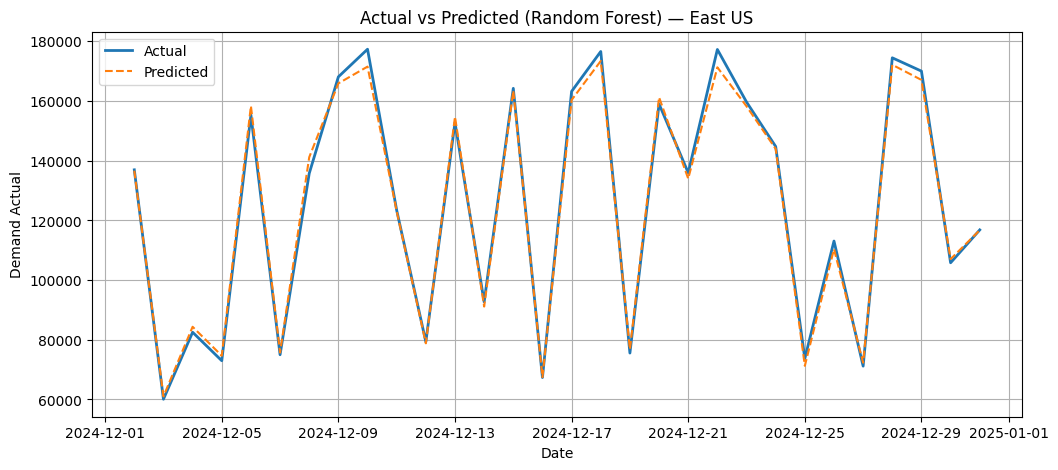

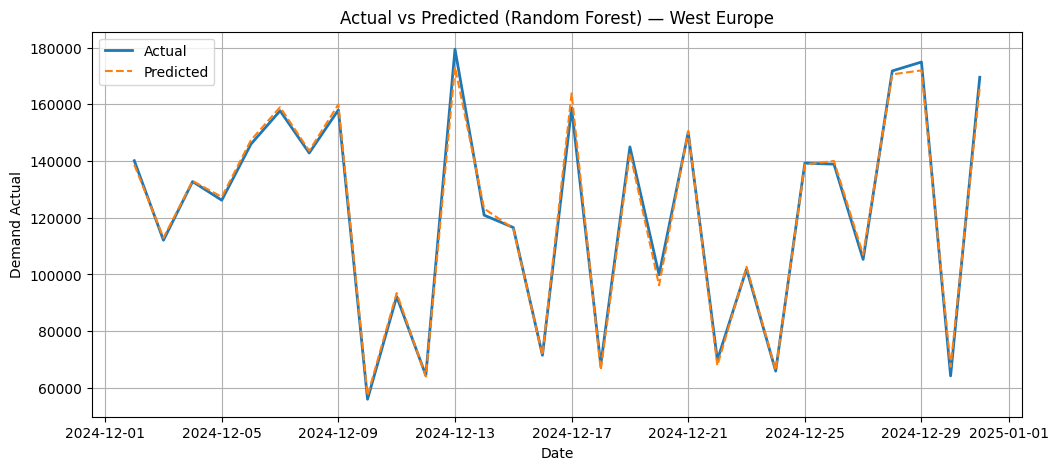

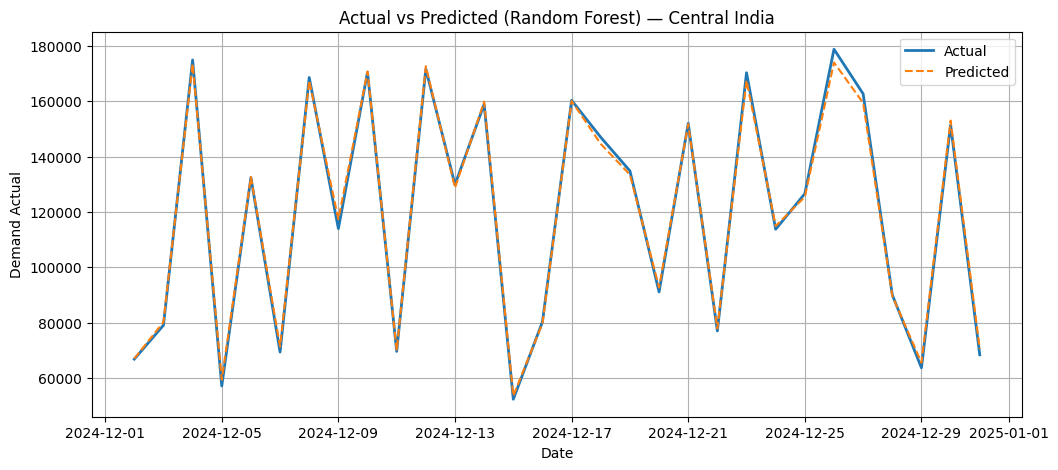

In [0]:
import matplotlib.pyplot as plt

for region in compute_regions:
    y_test = compute_data[region]["test"]
    y_pred = rf_results[region]["forecast"]

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
    plt.plot(y_pred.index, y_pred.values, label="Predicted", linestyle="--")
    plt.title(f"Actual vs Predicted (Random Forest) — {region}")
    plt.xlabel("Date")
    plt.ylabel("Demand Actual")
    plt.legend()
    plt.grid(True)
    plt.show()


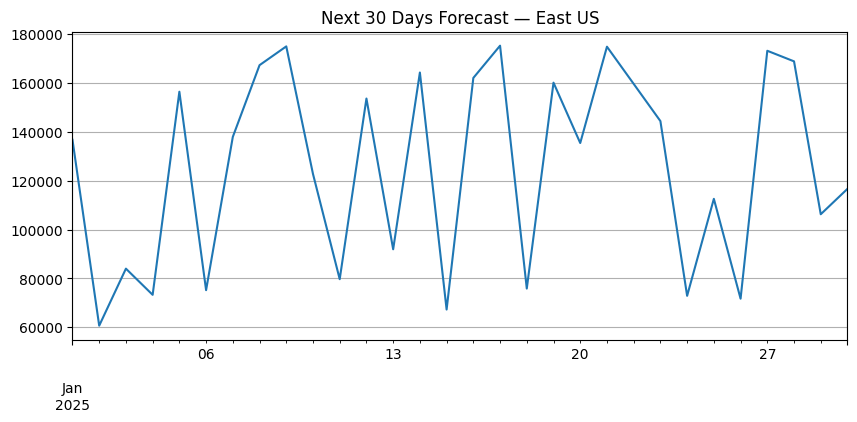

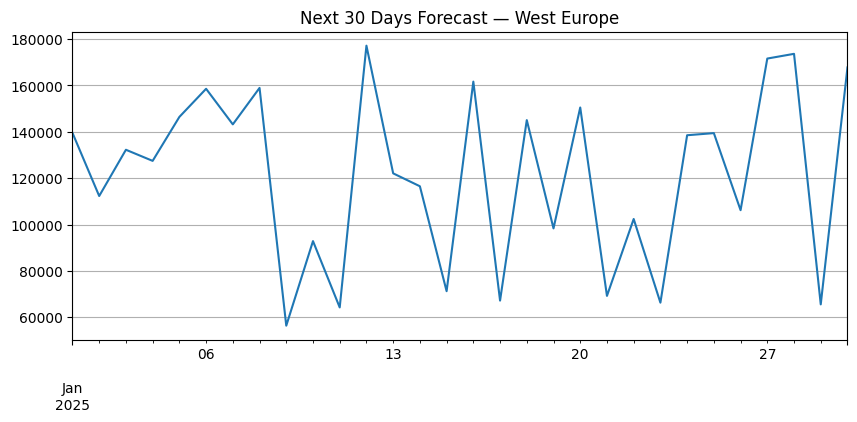

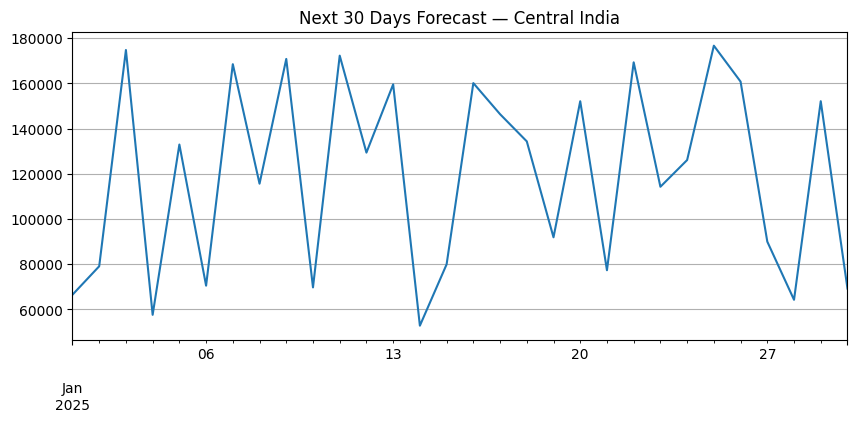

In [0]:
for region in compute_regions:
    final_rf_forecasts[region].plot(figsize=(10,4), title=f"Next 30 Days Forecast — {region}")
    plt.grid(True)
    plt.show()


In [0]:
import pandas as pd

comparison_data = {
    "Region": compute_regions,
    "ARIMA": [arima_results[r]["mape"] for r in compute_regions],
    "SARIMAX": [sarimax_results[r]["mape"] for r in compute_regions],
    "Holt_Winters": [holt_results[r]["mape"] for r in compute_regions],
    "Random_Forest": [rf_results[r]["mape"] for r in compute_regions],
    "XGBoost": [xgb_results[r]["mape"] for r in compute_regions]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Region,ARIMA,SARIMAX,Holt_Winters,Random_Forest,XGBoost
0,East US,33.507355,31.198227,31.183740,1.560653,1.520013
1,West Europe,32.594928,33.700911,31.639215,1.460309,1.631734
2,Central India,38.923861,38.373700,39.372032,1.349094,1.405230


In [0]:
comparison_spark = spark.createDataFrame(comparison_df)
display(comparison_spark)


Region,ARIMA,SARIMAX,Holt_Winters,Random_Forest,XGBoost
East US,33.50735493869609,31.198226639898074,31.183740002667648,1.5606526957908233,1.5200134057473584
West Europe,32.59492825607141,33.70091073548295,31.639214945546946,1.4603094684919735,1.6317335027167983
Central India,38.92386112215068,38.37370039337595,39.37203235659517,1.3490938618305215,1.4052303767832388


In [0]:
output_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/model_comparison/"
comparison_spark.write.format("delta").mode("overwrite").save(output_path)


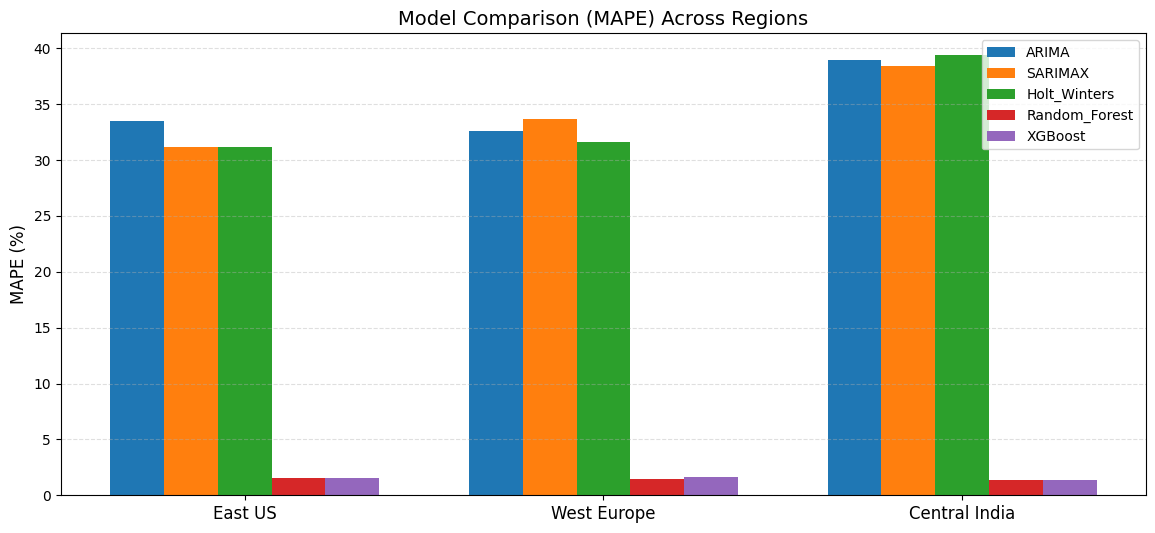

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names (all columns except Region)
models = ["ARIMA", "SARIMAX", "Holt_Winters", "Random_Forest", "XGBoost"]

# Number of regions
regions = comparison_df["Region"].values
x = np.arange(len(regions))

# Bar width
width = 0.15

plt.figure(figsize=(14, 6))

for i, model in enumerate(models):
    plt.bar(
        x + (i * width),
        comparison_df[model],
        width=width,
        label=model
    )

plt.xticks(x + width*2, regions, fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.title("Model Comparison (MAPE) Across Regions", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


In [0]:
import pandas as pd

# Build rows for each region
rows = []

for region in compute_regions:
    rf = rf_accuracy[region]
    xg = xgb_accuracy[region]

    rows.append({
        "Region": region,
        
        # Random Forest
        "RF_MAPE": rf["MAPE"],
        "RF_RMSE": rf["RMSE"],
        "RF_R2": rf["R2"],
        "RF_Accuracy": 100 - rf["MAPE"],

        # XGBoost
        "XGB_MAPE": xg["MAPE"],
        "XGB_RMSE": xg["RMSE"],
        "XGB_R2": xg["R2"],
        "XGB_Accuracy": 100 - xg["MAPE"],
    })

# Create DataFrame
rf_xgb_full_df = pd.DataFrame(rows)

rf_xgb_full_df


,Region,RF_MAPE,RF_RMSE,RF_R2,RF_Accuracy,XGB_MAPE,XGB_RMSE,XGB_R2,XGB_Accuracy
0,East US,1.560653,2516.007155,0.996085,98.439347,1.520013,2459.693356,0.996258,98.479987
1,West Europe,1.460309,2235.314911,0.996482,98.539691,1.631734,2610.084710,0.995204,98.368266
2,Central India,1.349094,1795.423143,0.998210,98.650906,1.405230,2038.793729,0.997692,98.594770


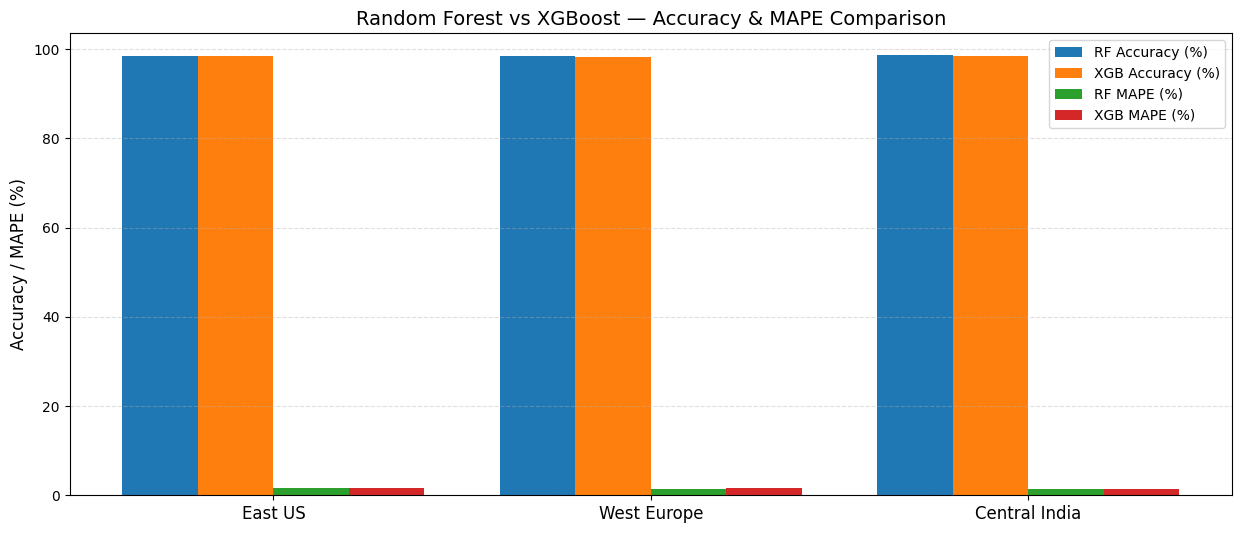

In [0]:
import matplotlib.pyplot as plt
import numpy as np

regions = rf_xgb_full_df["Region"].values

rf_acc = rf_xgb_full_df["RF_Accuracy"].values
xgb_acc = rf_xgb_full_df["XGB_Accuracy"].values

rf_mape = rf_xgb_full_df["RF_MAPE"].values
xgb_mape = rf_xgb_full_df["XGB_MAPE"].values

x = np.arange(len(regions))
width = 0.2

plt.figure(figsize=(15,6))

# Accuracy bars
plt.bar(x - width*1.5, rf_acc, width, label="RF Accuracy (%)", color="#1f77b4")
plt.bar(x - width/2, xgb_acc, width, label="XGB Accuracy (%)", color="#ff7f0e")

# MAPE bars
plt.bar(x + width/2, rf_mape, width, label="RF MAPE (%)", color="#2ca02c")
plt.bar(x + width*1.5, xgb_mape, width, label="XGB MAPE (%)", color="#d62728")

plt.xticks(x, regions, fontsize=12)
plt.ylabel("Accuracy / MAPE (%)", fontsize=12)
plt.title("Random Forest vs XGBoost — Accuracy & MAPE Comparison", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


In [0]:
rf_xgb_full_spark = spark.createDataFrame(rf_xgb_full_df)
display(rf_xgb_full_spark)


Region,RF_MAPE,RF_RMSE,RF_R2,RF_Accuracy,XGB_MAPE,XGB_RMSE,XGB_R2,XGB_Accuracy
East US,1.5606526957908233,2516.0071550421158,0.9960851314267567,98.43934730420918,1.5200134057473584,2459.693355788272,0.9962584170384304,98.47998659425264
West Europe,1.4603094684919735,2235.314910956807,0.9964822339786537,98.53969053150803,1.6317335027167983,2610.0847097390442,0.9952037841010913,98.3682664972832
Central India,1.3490938618305215,1795.4231431845371,0.9982099007795682,98.65090613816947,1.4052303767832388,2038.793728765111,0.9976917117356456,98.59476962321676


In [0]:
output_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/model_comparison_ml/"

rf_xgb_full_spark.write.format("delta").mode("overwrite").save(output_path)


In [0]:
import pandas as pd

forecast_rows = []

for region, series in final_rf_forecasts.items():
    df = pd.DataFrame({
        "date": series.index,
        "region": region,
        "service": "Compute",
        "forecast_demand_actual": series.values
    })

    forecast_rows.append(df)

# Combine everything
compute_forecast_df = pd.concat(forecast_rows)
compute_forecast_df = compute_forecast_df.sort_values(["region", "date"])

compute_forecast_df.head()


,date,region,service,forecast_demand_actual
0,2025-01-01,Central India,Compute,66495.495236
1,2025-01-02,Central India,Compute,79083.843095
2,2025-01-03,Central India,Compute,174785.156513
3,2025-01-04,Central India,Compute,57597.593556
4,2025-01-05,Central India,Compute,132964.260964


In [0]:
compute_forecast_spark = spark.createDataFrame(compute_forecast_df)
display(compute_forecast_spark)


date,region,service,forecast_demand_actual
2025-01-01T00:00:00Z,Central India,Compute,66495.4952362915
2025-01-02T00:00:00Z,Central India,Compute,79083.84309473708
2025-01-03T00:00:00Z,Central India,Compute,174785.15651320675
2025-01-04T00:00:00Z,Central India,Compute,57597.59355555554
2025-01-05T00:00:00Z,Central India,Compute,132964.26096359923
2025-01-06T00:00:00Z,Central India,Compute,70512.5621349114
2025-01-07T00:00:00Z,Central India,Compute,168517.70852525096
2025-01-08T00:00:00Z,Central India,Compute,115626.63971048385
2025-01-09T00:00:00Z,Central India,Compute,170825.20523563633
2025-01-10T00:00:00Z,Central India,Compute,69734.52363587203


In [0]:
output_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/forecast_compute/"

compute_forecast_spark.write.format("delta").mode("overwrite").save(output_path)


In [0]:
compute_forecast_spark.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("abfss://gold@azuresupply2605.dfs.core.windows.net/export_single/compute_forecast_single/")


In [0]:
comparison_spark.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("abfss://gold@azuresupply2605.dfs.core.windows.net/export_single/model_comparison_all_models/")


In [0]:
rf_xgb_full_spark.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("abfss://gold@azuresupply2605.dfs.core.windows.net/export_single/model_comparison_rf_xgb/")


In [0]:
from pyspark.sql import functions as F
import pandas as pd

storage_regions = ["East US", "West Europe", "Central India"]
storage_data = {}
horizon = 30

for region in storage_regions:
    sdf = (
        gold_df
        .filter((F.col("service") == "Storage") & (F.col("region") == region))
        .select("date", "storage_tb")
        .orderBy("date")
    )

    pdf = sdf.toPandas()
    pdf["date"] = pd.to_datetime(pdf["date"])
    pdf = pdf.sort_values("date")
    pdf = pdf.set_index("date")

    y = pdf["storage_tb"]

    train = y.iloc[:-horizon]
    test  = y.iloc[-horizon:]

    storage_data[region] = {
        "full": y,
        "train": train,
        "test": test
    }

    print(f"{region} — Train: {len(train)}, Test: {len(test)}")


East US — Train: 1797, Test: 30
West Europe — Train: 1797, Test: 30
Central India — Train: 1797, Test: 30


In [0]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

storage_arima = {}

for region, d in storage_data.items():
    y_train = d["train"]
    y_test  = d["test"]

    model = auto_arima(y_train, seasonal=False, suppress_warnings=True)
    forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)

    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    print(f"ARIMA MAPE — {region}: {mape:.2f}%")

    storage_arima[region] = {"forecast": forecast, "mape": mape}


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run brawny-pig-635 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/8038292eafac47f2a0006dc72af7d258
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA MAPE — East US: 37.73%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rebellious-gull-71 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/9313f917387a451b8e75b183b144c085
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adaptable-goose-778 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/c13d9a78c00948c6b93c7866f45df59f
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA MAPE — West Europe: 61.90%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-crane-812 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/848b02e76e66470d84445ac9969fe2a8
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA MAPE — Central India: 39.87%


In [0]:
import statsmodels.api as sm

storage_sarimax = {}

for region, d in storage_data.items():
    y_train = d["train"]
    y_test  = d["test"]

    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = model.forecast(steps=len(y_test))
    forecast = pd.Series(forecast, index=y_test.index)

    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    print(f"SARIMAX MAPE — {region}: {mape:.2f}%")

    storage_sarimax[region] = {"forecast": forecast, "mape": mape}


SARIMAX MAPE — East US: 37.77%
SARIMAX MAPE — West Europe: 47.94%
SARIMAX MAPE — Central India: 38.53%


In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

storage_holt = {}

for region, d in storage_data.items():
    y_train = d["train"]
    y_test  = d["test"]

    model = ExponentialSmoothing(
        y_train,
        trend="add",
        seasonal="add",
        seasonal_periods=7
    ).fit()

    forecast = model.forecast(len(y_test))
    forecast = pd.Series(forecast, index=y_test.index)

    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    print(f"Holt-Winters MAPE — {region}: {mape:.2f}%")

    storage_holt[region] = {"forecast": forecast, "mape": mape}


Holt-Winters MAPE — East US: 37.82%
Holt-Winters MAPE — West Europe: 48.00%
Holt-Winters MAPE — Central India: 38.15%


In [0]:
from sklearn.ensemble import RandomForestRegressor

storage_rf = {}

feature_cols = [
    "usage_lag_1", "usage_lag_7",
    "week_over_week_growth", "seasonality_factor",
    "cloud_demand_index", "gdp_growth",
    "inflation", "competitor_price_index"
]

for region in storage_regions:
    sdf = (
        gold_df
        .filter((F.col("service") == "Storage") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    X = sdf[feature_cols]
    y = sdf["storage_tb"]

    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]

    model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    preds = pd.Series(model.predict(X_test), index=y_test.index)
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    print(f"Random Forest MAPE — {region}: {mape:.2f}%")

    storage_rf[region] = {"forecast": preds, "mape": mape}


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-perch-873 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/d152ab9936794c1484809f3c04113192
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — East US: 37.82%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nimble-grub-321 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/baf5621a6a5d46158a8df026a6805ea0
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — West Europe: 49.55%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-crow-168 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/b4a481ce21ee454ba594ab94d5eab624
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — Central India: 41.18%


In [0]:
from sklearn.ensemble import RandomForestRegressor

storage_rf = {}

feature_cols = [
    "usage_lag_1", "usage_lag_7",
    "week_over_week_growth", "seasonality_factor",
    "cloud_demand_index", "gdp_growth",
    "inflation", "competitor_price_index"
]

for region in storage_regions:
    sdf = (
        gold_df
        .filter((F.col("service") == "Storage") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    X = sdf[feature_cols]
    y = sdf["storage_tb"]

    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]

    model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    preds = pd.Series(model.predict(X_test), index=y_test.index)
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    print(f"Random Forest MAPE — {region}: {mape:.2f}%")

    storage_rf[region] = {"forecast": preds, "mape": mape}


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run incongruous-hawk-248 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/276334b601754cee9ca7cbb0fedea0f9
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — East US: 37.82%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run popular-trout-919 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/235f798bedbb4c96b21e061590beb3d9
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — West Europe: 49.55%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run able-ox-836 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/9854af6766664a7fb10e787149ad1693
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
Random Forest MAPE — Central India: 41.18%


In [0]:
import xgboost as xgb

storage_xgb = {}

for region in storage_regions:
    sdf = (
        gold_df
        .filter((F.col("service") == "Storage") & (F.col("region") == region))
        .orderBy("date")
        .toPandas()
    )

    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")
    sdf = sdf.set_index("date")

    X = sdf[feature_cols]
    y = sdf["storage_tb"]

    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]

    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = pd.Series(model.predict(X_test), index=y_test.index)

    mape = mean_absolute_percentage_error(y_test, preds) * 100
    print(f"XGBoost MAPE — {region}: {mape:.2f}%")

    storage_xgb[region] = {"forecast": preds, "mape": mape}


XGBoost MAPE — East US: 38.66%
XGBoost MAPE — West Europe: 50.68%
XGBoost MAPE — Central India: 43.69%


In [0]:
for region in storage_regions:
    print(region)
    sdf = storage_data[region]["full"]
    display(sdf.tail(15))


East US


date
2024-12-17     415
2024-12-18     378
2024-12-19    1149
2024-12-20    1141
2024-12-21     981
2024-12-22     887
2024-12-23     374
2024-12-24     992
2024-12-25     364
2024-12-26     922
2024-12-27    1040
2024-12-28     904
2024-12-29     923
2024-12-30    1136
2024-12-31    1121
Name: storage_tb, dtype: int32

West Europe


date
2024-12-17    1151
2024-12-18     672
2024-12-19     325
2024-12-20     526
2024-12-21     798
2024-12-22     443
2024-12-23    1063
2024-12-24     339
2024-12-25     323
2024-12-26    1142
2024-12-27     541
2024-12-28     385
2024-12-29     760
2024-12-30    1081
2024-12-31     386
Name: storage_tb, dtype: int32

Central India


date
2024-12-17     849
2024-12-18     893
2024-12-19     387
2024-12-20     593
2024-12-21     623
2024-12-22     441
2024-12-23     678
2024-12-24    1011
2024-12-25     371
2024-12-26    1062
2024-12-27     861
2024-12-28     786
2024-12-29     795
2024-12-30    1106
2024-12-31     643
Name: storage_tb, dtype: int32

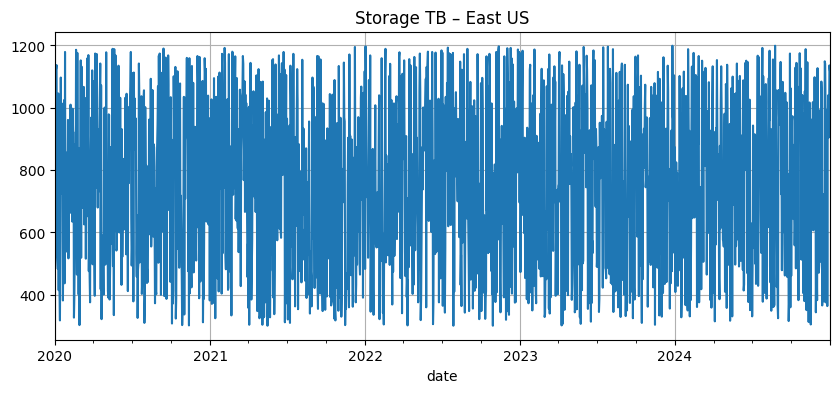

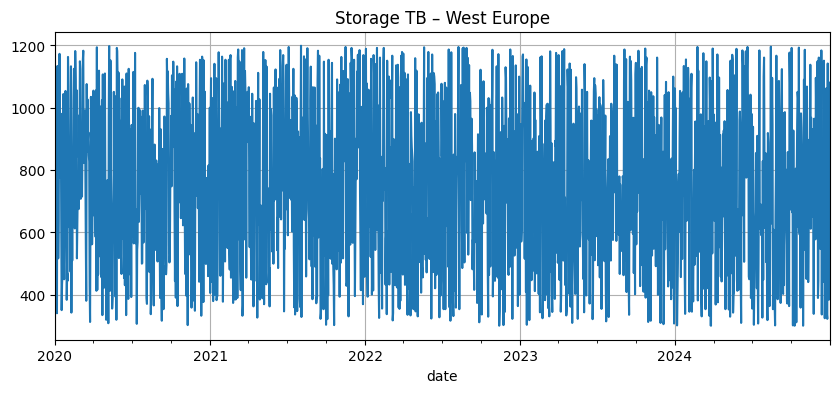

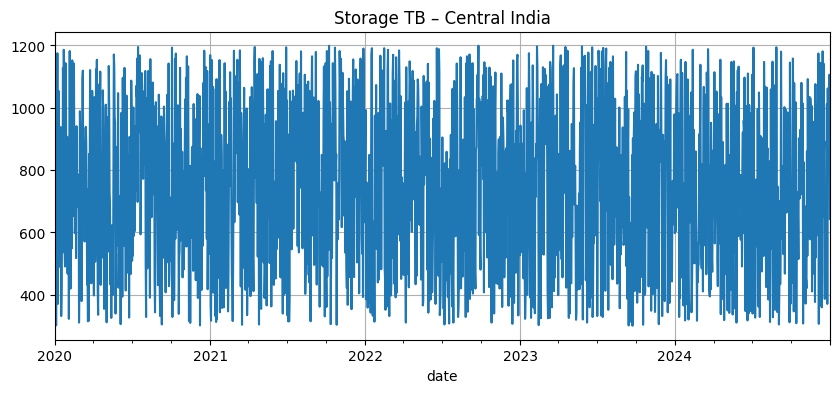

In [0]:
import matplotlib.pyplot as plt

for region in storage_regions:
    storage_data[region]["full"].plot(figsize=(10,4), title=f"Storage TB – {region}")
    plt.grid(True)
    plt.show()


In [0]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

ma_results = {}

windows = [7, 14, 30]  # moving average windows
horizon = 30

for region in storage_regions:
    y = storage_data[region]["full"]
    train = y.iloc[:-horizon]
    test  = y.iloc[-horizon:]

    region_results = {}

    for w in windows:
        ma_forecast = train.rolling(window=w).mean().iloc[-1]  # last MA value
        preds = pd.Series([ma_forecast] * horizon, index=test.index)

        mape = mean_absolute_percentage_error(test, preds) * 100

        region_results[f"MA_{w}"] = {
            "mape": mape,
            "forecast_value": ma_forecast,
            "prediction_series": preds
        }

        print(f"{region} — MA({w}) MAPE = {mape:.2f}%")

    ma_results[region] = region_results
    print("--------------------------------------")


East US — MA(7) MAPE = 36.21%
East US — MA(14) MAPE = 36.44%
East US — MA(30) MAPE = 36.81%
--------------------------------------
West Europe — MA(7) MAPE = 57.02%
West Europe — MA(14) MAPE = 53.61%
West Europe — MA(30) MAPE = 53.51%
--------------------------------------
Central India — MA(7) MAPE = 36.81%
Central India — MA(14) MAPE = 38.26%
Central India — MA(30) MAPE = 38.86%
--------------------------------------


In [0]:
#timepass
from pyspark.sql import functions as F

# Filter storage rows only
storage_monthly_df = (
    gold_df
    .filter(F.col("service") == "Storage")
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .groupBy("region", "year", "month")
    .agg(
        F.avg("storage_tb").alias("storage_tb_monthly_avg"),
        F.sum("storage_tb").alias("storage_tb_monthly_sum"),
        F.max("date").alias("latest_date")
    )
    .orderBy("region", "year", "month")
)

display(storage_monthly_df)


region,year,month,storage_tb_monthly_avg,storage_tb_monthly_sum,latest_date
Central India,2020,1,788.4193548387096,24441,2020-01-31
Central India,2020,2,764.5172413793103,22171,2020-02-29
Central India,2020,3,742.9677419354839,23032,2020-03-31
Central India,2020,4,800.3666666666667,24011,2020-04-30
Central India,2020,5,692.0,21452,2020-05-31
Central India,2020,6,724.3,21729,2020-06-30
Central India,2020,7,901.0967741935484,27934,2020-07-31
Central India,2020,8,794.7096774193549,24636,2020-08-31
Central India,2020,9,702.3333333333334,21070,2020-09-30
Central India,2020,10,717.2903225806451,22236,2020-10-31


In [0]:
storage_monthly_pd = storage_monthly_df.toPandas()
storage_monthly_pd["date"] = pd.to_datetime(
    storage_monthly_pd["year"].astype(str) + "-" + storage_monthly_pd["month"].astype(str) + "-01"
)
storage_monthly_pd = storage_monthly_pd.sort_values("date")


In [0]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

storage_monthly_arima = {}

for region in storage_regions:
    df = storage_monthly_pd[storage_monthly_pd["region"] == region]

    y = df["storage_tb_monthly_avg"].values
    train = y[:-1]
    test = y[-1:]  # last month

    model = auto_arima(train, seasonal=False, suppress_warnings=True)
    forecast = model.predict(1)

    mape = mean_absolute_percentage_error(test, forecast) * 100

    storage_monthly_arima[region] = {
        "forecast": forecast[0],
        "mape": mape
    }

    print(f"ARIMA Monthly — {region}: MAPE = {mape:.2f}%")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-robin-474 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/8812bb519c67439da6b963c7b353d9af
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA Monthly — East US: MAPE = 3.73%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abrasive-fly-674 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/81ac6e1c61f8463bbaafd2011a89cb5b
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bedecked-croc-362 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/e23542bfdebd47f09a1ad0e57be3f460
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA Monthly — West Europe: MAPE = 7.16%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-squirrel-86 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/a0e3229f1a5c48a7b9959bd2764939d3
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
ARIMA Monthly — Central India: MAPE = 0.87%


In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

storage_monthly_holt = {}

for region in storage_regions:
    df = storage_monthly_pd[storage_monthly_pd["region"] == region]

    y = df["storage_tb_monthly_avg"].values
    train = y[:-1]
    test = y[-1:]

    model = ExponentialSmoothing(train, trend="add", seasonal=None).fit()
    forecast = model.forecast(1)

    mape = mean_absolute_percentage_error(test, forecast) * 100

    storage_monthly_holt[region] = {
        "forecast": forecast[0],
        "mape": mape
    }

    print(f"Holt-Winters Monthly — {region}: MAPE = {mape:.2f}%")


Holt-Winters Monthly — East US: MAPE = 3.59%
Holt-Winters Monthly — West Europe: MAPE = 5.86%
Holt-Winters Monthly — Central India: MAPE = 3.26%


In [0]:
# Aggregate feature columns monthly
feature_cols = [
    "usage_lag_1", "usage_lag_7",
    "week_over_week_growth", "seasonality_factor",
    "cloud_demand_index", "gdp_growth",
    "inflation", "competitor_price_index"
]

monthly_features = (
    gold_df
    .filter(F.col("service") == "Storage")
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .groupBy("region", "year", "month")
    .agg(*[F.avg(col).alias(col) for col in feature_cols],
         F.avg("storage_tb").alias("storage_tb_monthly_avg"))
)

monthly_pd = monthly_features.toPandas()
monthly_pd["date"] = pd.to_datetime(monthly_pd["year"].astype(str) + "-" + monthly_pd["month"].astype(str) + "-01")
monthly_pd = monthly_pd.sort_values("date")


In [0]:
from sklearn.ensemble import RandomForestRegressor

storage_monthly_rf = {}

for region in storage_regions:
    df = monthly_pd[monthly_pd["region"] == region]

    X = df[feature_cols]
    y = df["storage_tb_monthly_avg"]

    X_train, X_test = X.iloc[:-1], X.iloc[-1:]
    y_train, y_test = y.iloc[:-1], y.iloc[-1:]

    model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)[0]
    mape = mean_absolute_percentage_error([y_test.values[0]], [pred]) * 100

    storage_monthly_rf[region] = {
        "forecast": pred,
        "mape": mape
    }

    print(f"RF Monthly — {region}: MAPE = {mape:.2f}%")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run loud-crab-307 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/0c0b405ad200491dac232151ab218c8d
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
RF Monthly — East US: MAPE = 11.35%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rebellious-squid-67 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/51c21e6eb2984660a1a54cdbdb385d09
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
RF Monthly — West Europe: MAPE = 7.51%


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run judicious-flea-199 at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767/runs/e57614e054a24330b076938d70b41757
🧪 View experiment at: https://adb-1466680768419701.1.azuredatabricks.net/ml/experiments/2844102899049767
RF Monthly — Central India: MAPE = 1.41%


In [0]:
import xgboost as xgb

storage_monthly_xgb = {}

for region in storage_regions:
    df = monthly_pd[monthly_pd["region"] == region]

    X = df[feature_cols]
    y = df["storage_tb_monthly_avg"]

    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05
    )

    model.fit(X.iloc[:-1], y.iloc[:-1])
    pred = model.predict(X.iloc[-1:].values)[0]

    mape = mean_absolute_percentage_error([y.iloc[-1]], [pred]) * 100

    storage_monthly_xgb[region] = {
        "forecast": pred,
        "mape": mape
    }

    print(f"XGBoost Monthly — {region}: MAPE = {mape:.2f}%")


XGBoost Monthly — East US: MAPE = 13.01%
XGBoost Monthly — West Europe: MAPE = 0.03%
XGBoost Monthly — Central India: MAPE = 2.59%


In [0]:
storage_monthly_compare = pd.DataFrame({
    "Region": storage_regions,
    "ARIMA": [storage_monthly_arima[r]["mape"] for r in storage_regions],
    "Holt_Winters": [storage_monthly_holt[r]["mape"] for r in storage_regions],
    "Random_Forest": [storage_monthly_rf[r]["mape"] for r in storage_regions],
    "XGBoost": [storage_monthly_xgb[r]["mape"] for r in storage_regions]
})

storage_monthly_compare


,Region,ARIMA,Holt_Winters,Random_Forest,XGBoost
0,East US,3.727642,3.588799,11.347706,13.008589
1,West Europe,7.161080,5.861043,7.510387,0.026839
2,Central India,0.866138,3.255140,1.409785,2.594119


In [0]:
storage_monthly_compare_spark = spark.createDataFrame(storage_monthly_compare)
display(storage_monthly_compare_spark)


Region,ARIMA,Holt_Winters,Random_Forest,XGBoost
East US,3.727641962997372,3.588799134571811,11.34770592410644,13.00858888454251
West Europe,7.161080346813707,5.861043258899025,7.510386945134585,0.02683913275276435
Central India,0.8661383936846238,3.255140407877396,1.4097854021167633,2.5941187340187586


In [0]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

prophet_mape = {}

for region in storage_regions:
    print(f"Calculating Prophet MAPE for: {region}")

    df = storage_monthly_pd_prophet[storage_monthly_pd_prophet["region"] == region][["ds", "y"]]

    # Train Prophet
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df.iloc[:-1])  # all except last month for training

    # Forecast 1 step ahead
    future = m.make_future_dataframe(periods=1, freq='MS')
    forecast = m.predict(future)

    predicted = forecast["yhat"].iloc[-1]
    actual = df["y"].iloc[-1]

    mape = mean_absolute_percentage_error([actual], [predicted]) * 100

    prophet_mape[region] = mape

    print(f"Prophet MAPE — {region}: {mape:.3f}%\n")


16:27:54 - cmdstanpy - INFO - Chain [1] start processing


Calculating Prophet MAPE for: East US


16:27:54 - cmdstanpy - INFO - Chain [1] done processing
16:27:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet MAPE — East US: 0.240%

Calculating Prophet MAPE for: West Europe


16:27:54 - cmdstanpy - INFO - Chain [1] done processing
16:27:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet MAPE — West Europe: 11.939%

Calculating Prophet MAPE for: Central India


16:27:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE — Central India: 8.704%



In [0]:
storage_monthly_compare["Prophet"] = [
    prophet_mape["East US"],
    prophet_mape["West Europe"],
    prophet_mape["Central India"]
]

display(storage_monthly_compare)


Region,ARIMA,Holt_Winters,Random_Forest,XGBoost,Prophet
East US,3.727641962997372,3.588799134571811,11.34770592410644,13.00858888454251,0.24030882665831652
West Europe,7.161080346813707,5.861043258899025,7.510386945134585,0.02683913275276435,11.939286654130377
Central India,0.8661383936846238,3.255140407877396,1.4097854021167633,2.5941187340187586,8.7044174507104


In [0]:
output_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/storage_model_comparison_monthly_full/"

storage_monthly_compare_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .save(output_path)



In [0]:
# Install if needed
# %pip install prophet

from prophet import Prophet
import pandas as pd


In [0]:
storage_monthly_pd_prophet = storage_monthly_pd.copy()

storage_monthly_pd_prophet = storage_monthly_pd_prophet.rename(columns={
    "date": "ds",
    "storage_tb_monthly_avg": "y"
})


In [0]:
prophet_forecasts = {}
future_months = 12

for region in storage_regions:
    print(f"Training Prophet for: {region}")

    df_region = storage_monthly_pd_prophet[
        storage_monthly_pd_prophet["region"] == region
    ][["ds", "y"]]

    # Fit Prophet model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive"
    )
    
    m.fit(df_region)

    # Create future dataframe
    future = m.make_future_dataframe(periods=future_months, freq="MS")

    # Predict
    forecast = m.predict(future)

    # Extract only future 12 months
    forecast_next_12 = forecast.tail(future_months)[["ds", "yhat"]]

    # Save
    prophet_forecasts[region] = forecast_next_12


16:22:46 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet for: East US


16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet for: West Europe


16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet for: Central India


16:22:47 - cmdstanpy - INFO - Chain [1] done processing


In [0]:
final_rows = []

for region, df in prophet_forecasts.items():
    df_region = pd.DataFrame({
        "forecast_month": df["ds"],
        "region": region,
        "service": "Storage",
        "forecast_storage_tb": df["yhat"]
    })
    final_rows.append(df_region)

storage_12m_prophet_df = pd.concat(final_rows)
storage_12m_prophet_df = storage_12m_prophet_df.sort_values(["region", "forecast_month"])

storage_12m_prophet_df


,forecast_month,region,service,forecast_storage_tb
60,2025-01-01,Central India,Storage,631.244696
61,2025-02-01,Central India,Storage,715.845689
62,2025-03-01,Central India,Storage,746.128723
63,2025-04-01,Central India,Storage,738.848780
64,2025-05-01,Central India,Storage,723.440363
65,2025-06-01,Central India,Storage,700.372859
66,2025-07-01,Central India,Storage,748.217564
67,2025-08-01,Central India,Storage,725.445046
68,2025-09-01,Central India,Storage,706.107241
69,2025-10-01,Central India,Storage,730.100336


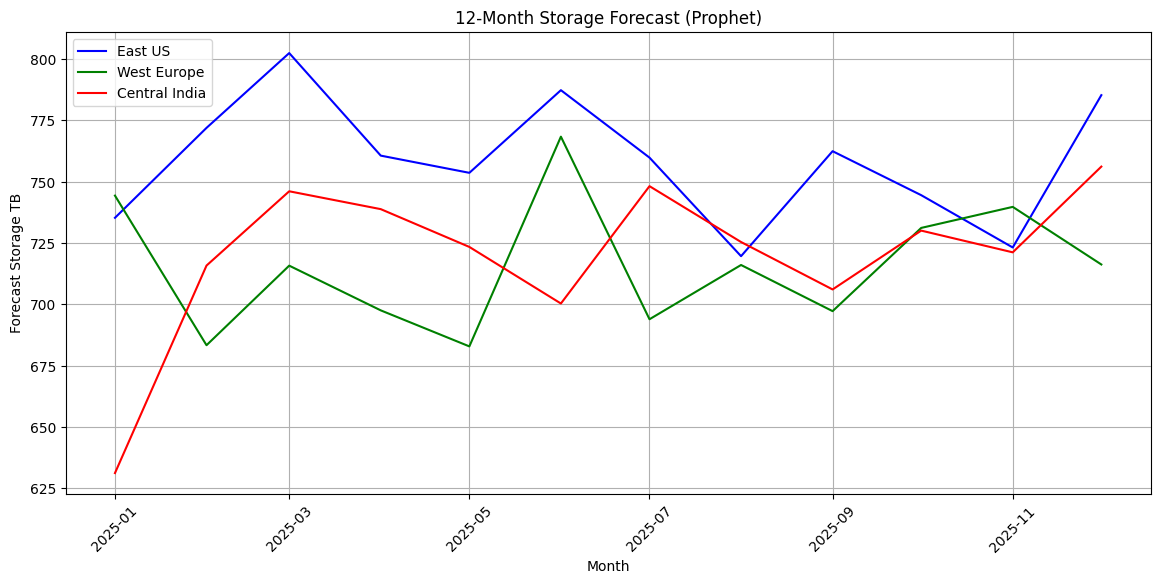

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

regions = ["East US", "West Europe", "Central India"]
colors = ["blue", "green", "red"]

for region, c in zip(regions, colors):
    df_r = storage_12m_prophet_df[storage_12m_prophet_df["region"] == region]
    plt.plot(df_r["forecast_month"], df_r["forecast_storage_tb"], label=region, color=c)

plt.title("12-Month Storage Forecast (Prophet)")
plt.xlabel("Month")
plt.ylabel("Forecast Storage TB")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.show()


In [0]:
# Convert Pandas DF → Spark DF
storage_12m_prophet_spark = spark.createDataFrame(storage_12m_prophet_df)

# Now write to GOLD
output_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/forecast_storage_monthly_12m_prophet/"

storage_12m_prophet_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .save(output_path)


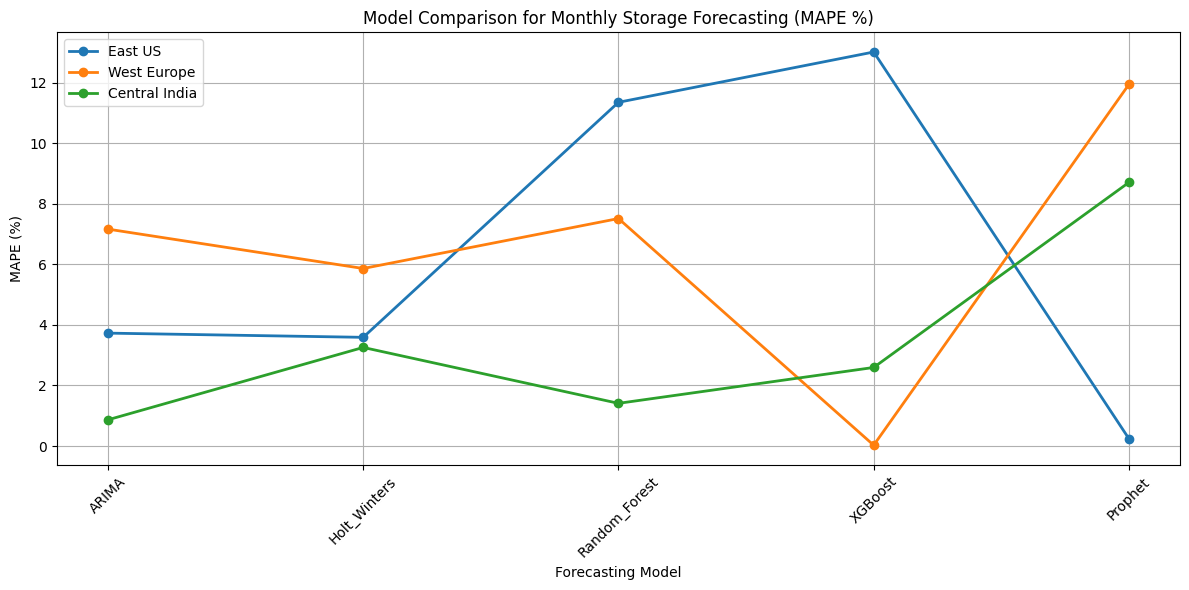

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------
# 1) (Optional) Recreate the table
#    Skip this block if you already have
#    `storage_monthly_compare` as a DataFrame
# ------------------------------------
data = {
    "Region": ["East US", "West Europe", "Central India"],
    "ARIMA": [3.727641962997372, 7.161080346813707, 0.8661383936846238],
    "Holt_Winters": [3.588799134571811, 5.861043258899025, 3.255140407877396],
    "Random_Forest": [11.34770592410644, 7.510386945134585, 1.4097854021167633],
    "XGBoost": [13.00858888454251, 0.02683913275276435, 2.5941187340187586],
    "Prophet": [0.240, 11.939, 8.704]
}

storage_monthly_compare = pd.DataFrame(data)

# ------------------------------------
# 2) Melt to long format for plotting
# ------------------------------------
compare_long = storage_monthly_compare.melt(
    id_vars="Region",
    var_name="Model",
    value_name="MAPE"
)

# ------------------------------------
# 3) Line chart: MAPE vs Model per Region
# ------------------------------------
plt.figure(figsize=(12, 6))

for region in storage_monthly_compare["Region"]:
    subset = compare_long[compare_long["Region"] == region]
    plt.plot(
        subset["Model"],
        subset["MAPE"],
        marker="o",
        linewidth=2,
        label=region
    )

plt.title("Model Comparison for Monthly Storage Forecasting (MAPE %)")
plt.xlabel("Forecasting Model")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
storage_compare_spark = spark.createDataFrame(storage_monthly_compare)


In [0]:
storage_compare_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/export_single/storage_model_comparison/"

storage_compare_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .save(storage_compare_path)


In [0]:
storage_12m_prophet_spark = spark.createDataFrame(storage_12m_prophet_df)


In [0]:
storage_12m_path = "abfss://gold@azuresupply2605.dfs.core.windows.net/export_single/storage_12m_forecast/"

storage_12m_prophet_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .save(storage_12m_path)
